In [35]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd', context='notebook', ticks=True, grid=False)

warnings.filterwarnings("ignore")
np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

FREERUN = 20  # Extra predicition time-steps after test data
deltaT = .02      # Number of extra free-running steps  int(20/.02) 

rho = 28.0
sigma = 10.0
beta = 8/3

# Lorenz 1963
def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]             # Initial point
t = np.arange(0,300+FREERUN,deltaT)  # Total of 320 full steps with deltaT=.02
states = odeint(f,state0,t)

mu = np.mean(states, axis=0)       # Get mean for each of x,y,z
signal = (states - mu)[:,[0,1,2]]  # Mean center the data
M = signal.shape[0] - int(FREERUN/deltaT)  # Length of train plus test... no freerun
#N = 25                                 # Reservoir matrix size
K = 3                                  # Input dimension
L = 3                                  # Output dimension
RF = .5                                # For feedback <--- not implemented
TEST = 1000                            # length of test
LEAD = 100                            # Number of points to plot before test
BURNIN = 100                           # Number of steps ignored for random x0 to fade
REG = 1e-8                             # Regularization factor for ridge regression
TRAINLENGTH = M-TEST    

MINMAXS = np.max(signal[:TRAINLENGTH+TEST],axis=0)-np.min(signal[:TRAINLENGTH+TEST],axis=0)
RGS = [(-19.5,19.5),(-27,27),(-25,25)]
BINS = 50

print(f'Signal length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000


In [36]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    #pdb.set_trace()
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device('cuda'))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    #pdb.set_trace
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device('cuda')).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device('cuda'))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    #pdb.set_trace()
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device('cuda'))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def cosFactor(av,bv):
    #pdb.set_trace()
    f = 0
    cosSIM = 1.0
    try:
        currentCOS = np.dot(av, bv)/(np.linalg.norm(av)*np.linalg.norm(bv))
    except: # catch *all* exceptions
        f = sys.exc_info()[0]
        print(f)
        currentCOS = [0.0] # If error default orthogonal
        
    
    if(not f):
        if(np.any(np.isnan(currentCOS))): # If NaN default to orthogonal
            currentCOS = [0.0]
        cosSIM = 1 - currentCOS[0]
    else:
        print('Error f')
    return cosSIM

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

def distribution(dataP,dataQ,mn,mx, bins=50):
    emptyFlag = []
    measureP,bnlocs = np.histogram(dataP, bins=bins, range=(mn,mx))
    measureQ,_ = np.histogram(dataQ, bins=bins, range=(mn,mx))
    for i in range(bins):
        if((measureP[i] == 0) or (measureQ[i] == 0)):
            emptyFlag.append(False)
        else:
            emptyFlag.append(True)
    #pdb.set_trace()
    measureP = measureP[emptyFlag]
    measureQ = measureQ[emptyFlag]    
    pmfP = (measureP)/np.linalg.norm(measureP)
    pmfQ = (measureQ)/np.linalg.norm(measureQ)
    kl = np.sum(rel_entr(pmfP,pmfQ))
    return (kl,pmfP,pmfQ, bnlocs)

## Training Loop for gp_minimize

In [37]:
# Values to search with gp_optimize
#space = [Real(.5,.7, name='a'),
#         Real(.6,.8, name='sr'),
#         Real(2,4, name='amp'),
#         Real(.001,.5, name='ri'),
#         Real(2,4, name='rr')
#        ]

#space = [Real(.001, 1, name='a'),
#         Real(.001, 8., name='sr'),
#         Real(.001, 1, name='amp'), 
#         Real(.001, 1., name='ri'),
#         Real(.001, 5., name='rr')
#        ]
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, \
           alphas, rhos, gammas, inScales, resScales# For run-time output
    # Avoid copying from CPU to GPU    
    # Init container variables directly on GPU
    ut = torch.zeros((K,1),dtype=dtype, device=torch.device('cuda')) 
    tp = torch.zeros((K,1),dtype=dtype, device=torch.device('cuda'))
    
    # Init matrices directly on GPU
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1) # Concat to one matrix for faster compute
    xt, yt = set_vectorsGPU(N,L,rr) # On GPU random init x0 and container yt   
    
    # GPU containers for Phi and y in regression solve (bad naming... reused var name)
    # Here states is the Phi matrix
    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype, device='cuda:0')
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device='cuda:0')
    # Loop through training data and accumulate states for ridge-regression solve
    for i in range(TRAINLENGTH):
        ut[:,0] = s[i]                         # Forcing u[t] 
        tp[:,0] = s[i+1]                       # True target for prediction u[t+1] 
        uxy = torch.cat((ut,xt,yt),0)          # Concat vectors for use with Wnet
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp) # x[t+1] = F(x[t],u[t])
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1) # Transpose as row for Phi
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy() 
    #target = targets.detach().cpu().numpy()
    
    
    ############################             Ridge Regression solve on CPU (fast!)
    torch.cuda.synchronize()    # GPU threads were running asynchronous
                                # Use signal since already sitting on CPU side
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
                                # Move back to GPU
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda() # Trained Wout
    torch.cuda.synchronize()    # Make sure synchronized before prediction pass
    ############################
    
    # Container for all predictions... Burnin --> train --> test --> freerun
    predictions = torch.zeros((M+int(FREERUN/deltaT),K),
                              dtype=dtype,
                              device=torch.device('cuda'))
    # Reset new initial vectors for prediction pass
    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/deltaT)):
        if(i < TRAINLENGTH):
            ut[:,0] = s[i]
        else:
            #pdb.set_trace()
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        #pdb.set_trace()
        predictions[i] = yt1[:,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()  # Move predictions onto CPU (numpy)
    
    nrmse = np.ones((K,1))*1000
    #if((np.any(np.isnan(yHat_GPU))) or (np.any(np.isinf(yHat_GPU)))):
    #    nrmse = nrmse_fail
    #else:
    try:
        for i in range(K):
            nrmse[i,0] = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST,i],
                                   MINMAXS[i])
    except: 
        pass
    #### Pearson Correlation <=> Cosine Distance    
    #pdb.set_trace()
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST]
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST])
    dists = np.zeros(K)
    for i in range(K):
        avec = av[:,i].reshape(TEST,1)
        bvec = bv[:,i].reshape(TEST,1)
        num = np.squeeze(np.dot(avec.T,bvec))
        den = np.linalg.norm(avec)*np.linalg.norm(bvec)
        cosine_similarity = num/den
        cosine_distance = 1 - cosine_similarity
        dists[i] = cosine_distance
        
    loss = np.max(nrmse+dists)
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error)&(loss<.9)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(15,12))
        plt.subplot(3,1,1)
        plt.plot(signal[TRAINLENGTH-LEAD:,0], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,0], label='X pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,2)
        plt.plot(signal[TRAINLENGTH-LEAD:,1], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,1], label='Y pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(signal[TRAINLENGTH-LEAD:,2], label='Target')
        plt.plot(yHat_GPU[TRAINLENGTH-LEAD:,2], label='Z pred')
        plt.axvline(LEAD,c='r',linestyle='dashed')
        plt.ylim(-20,20)
        plt.legend()
        
        plt.show()
        fig.savefig(f'./Saved_Models/L3D_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_Wnet',wnet)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_Preds',yHat_GPU)
        np.save(f'./L3D_Saved_Models/L3D_it{counter}_{N}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {np.max(nrmse):.3f} CD {np.max(dists):.3f}')
    counter += 1
    return loss

## Parameter Search with gp_minimize

********** Size100 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 386.764600   Time 6.53  Best 1000.000 NRMSE 385.734 CD 1.031
Iter: 2 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.502707   Time 5.33  Best 1000.000 NRMSE 0.290 CD 1.213
Iter: 7 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1015973368953420230548684688850944.000 CD 1.000
Iter: 9 #### Diagnostic 1.369093   Time 5.78  Best 1000.000 NRMSE 0.283 CD 1.086
Iter: 10 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 388945.905 CD 1.

Iter: 92 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.383880   Time 5.50  Best 1000.000 NRMSE 0.317 CD 1.066
Iter: 95 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.342934   Time 5.45  Best 1000.000 NRMSE 0.296 CD 1.047
Iter: 99 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan

Run: 0 Best result = 1.1150079868120595
a = 0.835763310189281
sr = 1.4515546816815117
amp = 0.5956420840589968
ri = 0.4792371758137317
rr = 4.39761141882791
********** Size100 -- Run 1 ***********
Iter: 0 #### Diagnostic 1.307059   Time 5.70  Best 1000.000 NRMSE 0.321 CD 0.986
Iter: 1 #### Diagnostic 345.448846   Time

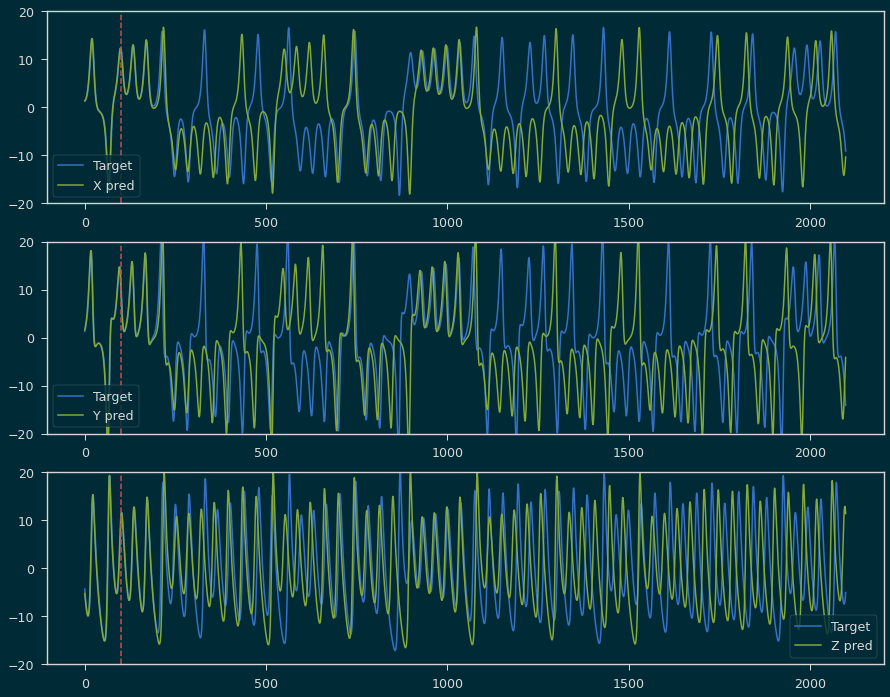

 Iter=39 a=0.698 sr=6.723 amp=0.897  ri=0.108 rr=0.063 loss=0.834626


Iter: 39 #### Diagnostic 0.834626   Time 6.09  Best 0.835 NRMSE 0.223 CD 0.611
Iter: 40 #### Diagnostic 1.313291   Time 5.54  Best 0.835 NRMSE 0.303 CD 1.010
Iter: 41 #### Diagnostic 1000.000000   Time 5.54  Best 0.835 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.66  Best 0.835 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.71  Best 0.835 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.64  Best 0.835 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.97  Best 0.835 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.83  Best 0.835 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.71  Best 0.835 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.81  Best 0.835 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.48  Best 0.835 NRMSE 20520809857.534 CD 0.982
Iter: 50 #### D

Iter: 33 #### Diagnostic 1.372119   Time 5.26  Best 1000.000 NRMSE 0.335 CD 1.037
Iter: 34 #### Diagnostic 1.481788   Time 5.41  Best 1000.000 NRMSE 0.313 CD 1.169
Iter: 35 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 22988.975 CD 1.086
Iter: 36 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.426955   Time 6.76  Best 1000.000 NRMSE 0.360 CD 1.067
Iter: 40 #### Diagnostic 1000.000000   Time 8.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.552849   Time 7.90  Best 1000.000 NRMSE 0.317 CD 1.236
Iter: 42 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 54948248747688919040.000 CD 1.000
Iter: 44 #### Diagnostic 1000.000000   Time 5.46 

Iter: 25 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.389918   Time 5.26  Best 1000.000 NRMSE 0.343 CD 1.047
Iter: 28 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.268802   Time 5.50  Best 1000.000 NRMSE 0.285 CD 0.984
Iter: 31 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 5.53  Best 1000.00

Iter: 17 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.339824   Time 5.69  Best 1000.000 NRMSE 0.315 CD 1.025
Iter: 19 #### Diagnostic 1000.000000   Time 5.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.306081   Time 5.50  Best 1000.000 NRMSE 0.293 CD 1.013
Iter: 23 #### Diagnostic 1.420163   Time 5.50  Best 1000.000 NRMSE 0.357 CD 1.063
Iter: 24 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 14614387828.934 CD 1.039
Iter: 27 #### Diagnostic 1.630529   Time 5.89  Best 1000.000 NRMSE 0.604 CD 1.026
Iter: 28 #### Diagnostic 1000.000000   Time 5.81  Best 1000.0

Iter: 3 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.703096   Time 5.35  Best 1000.000 NRMSE 0.701 CD 1.002
Iter: 5 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan


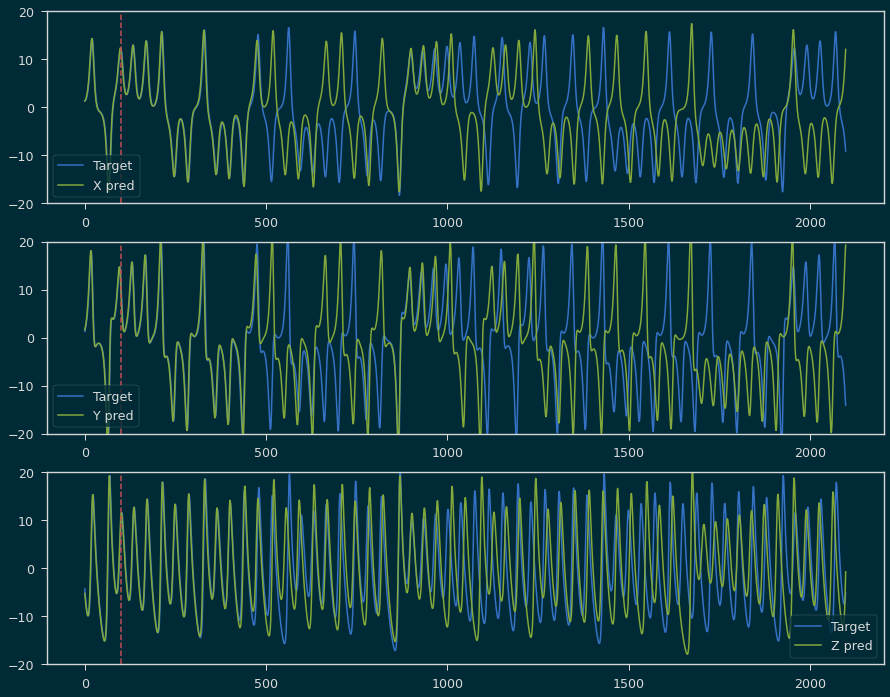

 Iter=6 a=0.622 sr=3.540 amp=0.898  ri=0.070 rr=2.533 loss=0.778316


Iter: 6 #### Diagnostic 0.778316   Time 6.38  Best 0.778 NRMSE 0.219 CD 0.559
Iter: 7 #### Diagnostic 1000.000000   Time 5.71  Best 0.778 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.28  Best 0.778 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 5.84  Best 0.778 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.833295   Time 5.85  Best 0.778 NRMSE 0.863 CD 0.971
Iter: 11 #### Diagnostic 1.383760   Time 5.79  Best 0.778 NRMSE 0.294 CD 1.090
Iter: 12 #### Diagnostic 1000.000000   Time 5.87  Best 0.778 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.70  Best 0.778 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.77  Best 0.778 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 5.62  Best 0.778 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.59  Best 0.778 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.045986

Iter: 0 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 45.132814   Time 5.33  Best 1000.000 NRMSE 44.097 CD 1.036
Iter: 2 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.089218   Time 5.51  Best 1000.000 NRMSE 0.263 CD 0.826
Iter: 6 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 

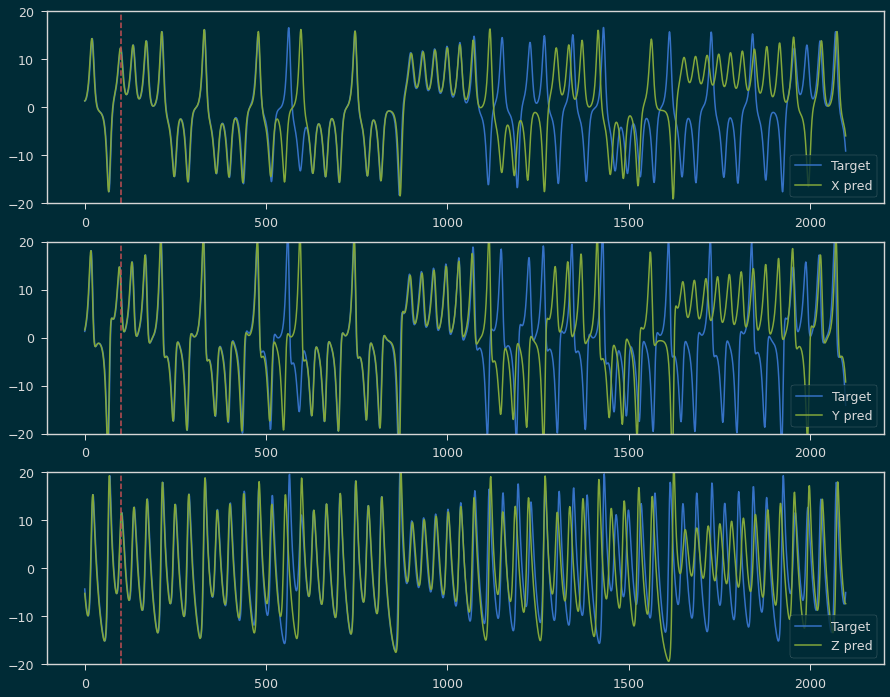

 Iter=29 a=0.858 sr=6.016 amp=0.364  ri=0.052 rr=3.815 loss=0.253017


Iter: 29 #### Diagnostic 0.253017   Time 6.18  Best 0.253 NRMSE 0.109 CD 0.144
Iter: 30 #### Diagnostic 1000.000000   Time 6.72  Best 0.253 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.52  Best 0.253 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.46  Best 0.253 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.45  Best 0.253 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.36  Best 0.253 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 5.47  Best 0.253 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.426010   Time 5.44  Best 0.253 NRMSE 0.317 CD 1.109
Iter: 37 #### Diagnostic 1.170167   Time 6.20  Best 0.253 NRMSE 0.264 CD 0.906
Iter: 38 #### Diagnostic 1000.000000   Time 8.06  Best 0.253 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.178616   Time 6.67  Best 0.253 NRMSE 0.275 CD 0.904
Iter: 40 #### Diagnostic 1000.00

Iter: 23 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.393950   Time 5.48  Best 1000.000 NRMSE 0.332 CD 1.062
Iter: 25 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 4735578115818106880.000 CD 1.000
Iter: 26 #### Diagnostic 1.369420   Time 5.51  Best 1000.000 NRMSE 0.299 CD 1.071
Iter: 27 #### Diagnostic 1.400064   Time 5.44  Best 1000.000 NRMSE 0.294 CD 1.106
Iter: 28 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 610490247342437760.000 CD 1.000
Iter: 32 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.464726

Iter: 16 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.410066   Time 5.25  Best 1000.000 NRMSE 0.331 CD 1.079
Iter: 19 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.242733   Time 5.68  Best 1000.000 NRMSE 0.280 CD 0.963
Iter: 27 #### Diagnostic 1000.000000   Time 5.73  Best 1000.00

Iter: 9 #### Diagnostic 1.431815   Time 5.45  Best 1000.000 NRMSE 0.386 CD 1.046
Iter: 10 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.360687   Time 5.64  Best 1000.000 NRMSE 0.307 CD 1.053
Iter: 16 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 134871140088348728623895777221017600.000 CD 1.000
Iter: 17 #### Diagnostic 1.338028   Time 5.77  Best 1000.000 NRMSE 0.304 CD 1.034
Iter: 18 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1315905570.382 CD 1.020
Iter: 20 #### Diagnostic 

Iter: 0 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 413912943581.766 CD 0.969
Iter: 1 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.378171   Time 5.40  Best 1000.000 NRMSE 0.331 CD 1.047
Iter: 10 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 397542822479330012911510380085248.000 CD 1.000
Iter: 11 #### Diagnostic 1.

Iter: 93 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.384432   Time 5.75  Best 1000.000 NRMSE 0.317 CD 1.067
Iter: 95 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan

Run: 0 Best result = 1.1038957844031034
a = 0.5948354975324227
sr = 0.8585825609248062
amp = 0.2100805936309223
ri = 0.8604663626103327
rr = 3.557430118528141
********** Size100 -- Run 1 ***********
Iter: 0 #### Diagnostic 1.232084   Time 5.49  Best 1000.000 NRMSE 0.279 CD 0.953
Iter: 1 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1039.267 CD 0.994
Iter: 2 #### Diagnostic 1000.00000

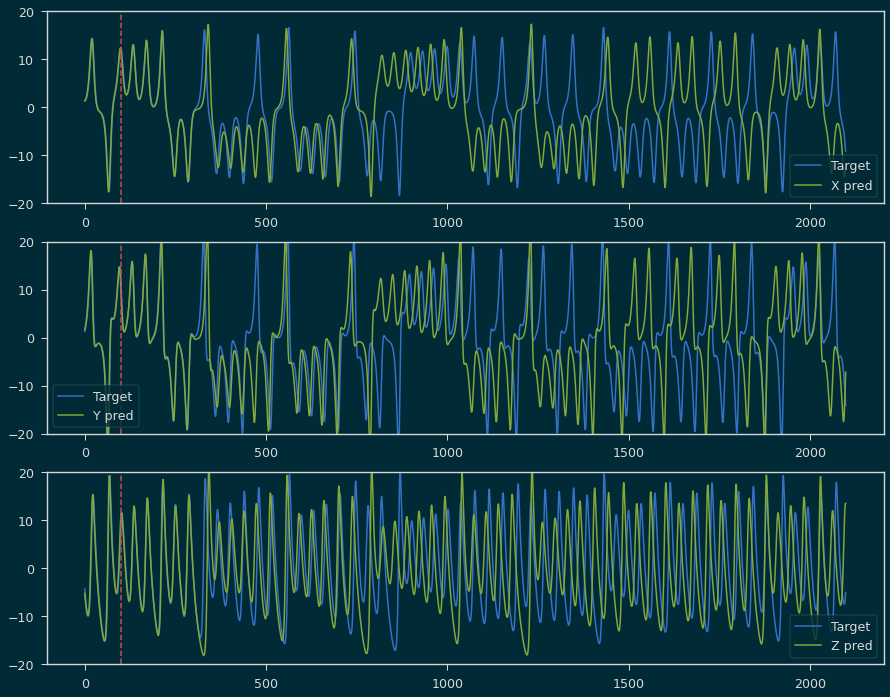

 Iter=39 a=0.698 sr=6.723 amp=0.897  ri=0.108 rr=0.063 loss=0.780883


Iter: 39 #### Diagnostic 0.780883   Time 6.04  Best 0.781 NRMSE 0.197 CD 0.583
Iter: 40 #### Diagnostic 1.363405   Time 5.46  Best 0.781 NRMSE 0.362 CD 1.001
Iter: 41 #### Diagnostic 1000.000000   Time 5.45  Best 0.781 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.40  Best 0.781 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.304225   Time 5.40  Best 0.781 NRMSE 0.293 CD 1.011
Iter: 44 #### Diagnostic 1000.000000   Time 5.43  Best 0.781 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.66  Best 0.781 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.29  Best 0.781 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.28  Best 0.781 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.27  Best 0.781 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.31  Best 0.781 NRMSE 1645018.436 CD 1.013
Iter: 50 #### Diagnosti

Iter: 33 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.212367   Time 5.47  Best 1000.000 NRMSE 0.282 CD 0.931
Iter: 35 #### Diagnostic 2.520689   Time 5.43  Best 1000.000 NRMSE 1.343 CD 1.178
Iter: 36 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.361645   Time 5.43  Best 1000.000 NRMSE 0.398 CD 0.964
Iter: 40 #### Diagnostic 1.649765   Time 5.27  Best 1000.000 NRMSE 0.686 CD 0.964
Iter: 41 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 145735334436931460749328384.000 CD 1.000
Iter: 42 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 235616173763128.438 CD 1.055
Iter: 44 #### Diagnostic 1000.00

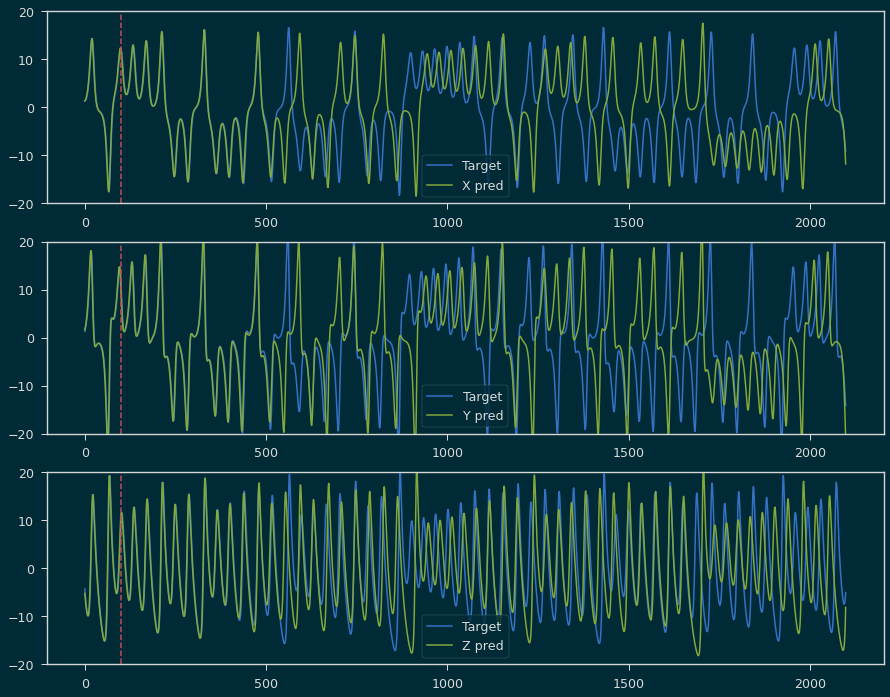

 Iter=93 a=0.938 sr=2.381 amp=0.986  ri=0.058 rr=3.010 loss=0.603477


Iter: 93 #### Diagnostic 0.603477   Time 6.02  Best 0.603 NRMSE 0.184 CD 0.419
Iter: 94 #### Diagnostic 1.190826   Time 5.28  Best 0.603 NRMSE 0.276 CD 0.915
Iter: 95 #### Diagnostic 1000.000000   Time 5.52  Best 0.603 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 60.435966   Time 5.29  Best 0.603 NRMSE 59.437 CD 0.999
Iter: 97 #### Diagnostic 1000.000000   Time 5.42  Best 0.603 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.253100   Time 5.43  Best 0.603 NRMSE 0.281 CD 0.972
Iter: 99 #### Diagnostic 1000.000000   Time 5.47  Best 0.603 NRMSE 1000.000 CD nan

Run: 2 Best result = 0.6034766730186889
a = 0.9383001844134272
sr = 2.381433918911849
amp = 0.9859158674074028
ri = 0.05818456209562565
rr = 3.0098018911423274
********** Size100 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.00

Iter: 85 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 504584241.771 CD 1.061
Iter: 86 #### Diagnostic 1.360959   Time 5.54  Best 1000.000 NRMSE 0.312 CD 1.049
Iter: 87 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.913332   Time 5.47  Best 1000.000 NRMSE 0.746 CD 1.167
Iter: 91 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 943547538229366.125 CD 0.988
Iter: 95 #### Diagnostic 1.380402   Time 5.35  Best 1000.000 NRMSE 0.313 CD 1.068
Iter: 96 #### Diagnostic 1.502047   Time 5.43 

Iter: 77 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.568615   Time 5.30  Best 1000.000 NRMSE 0.316 CD 1.253
Iter: 79 #### Diagnostic 1.300644   Time 5.44  Best 1000.000 NRMSE 0.281 CD 1.019
Iter: 80 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 498.454553   Time 5.35  Best 1000.000 NRMSE 497.478 CD 0.977
Iter: 87 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.43  Best 1000.00

Iter: 62 #### Diagnostic 1000.000000   Time 7.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 7.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 8.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 563100784.191 CD 0.989
Iter: 68 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 8.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 38637284767646466048.000 CD 1.000
Iter: 71 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 7.96  Best 1000.000 NRMSE 1741791933477611630516273569333248.000 CD 1.0

Iter: 54 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 2165624648579147366400.000 CD 1.000
Iter: 57 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.282542   Time 5.81  Best 1000.000 NRMSE 0.359 CD 0.923
Iter: 61 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.473592   Time 5.76  Best 1000.000 NRMSE 0.370 CD 1.104
Iter: 63 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 2706369437174846056469030735183872.000 CD 1.000
Iter: 65 #

Iter: 47 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 850307364656712068890624.000 CD 1.000
Iter: 49 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.273119   Time 5.37  Best 1000.000 NRMSE 0.310 CD 0.963
Iter: 51 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.329480   Time 5.53  Best 1000.000 NRMSE 0.369 CD 0.960
Iter: 53 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.957089   Time 5.45  Best 1000.000 NRMSE 0.903 CD 1.054
Iter: 56 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 

Iter: 39 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.313556   Time 5.47  Best 1000.000 NRMSE 0.287 CD 1.027
Iter: 42 #### Diagnostic 2.732440   Time 5.47  Best 1000.000 NRMSE 1.686 CD 1.046
Iter: 43 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.646288   Time 5.59  Best 1000.000 NRMSE 0.577 CD 1.069
Iter: 45 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.483327   Time 5.47  Best 1000.000 NRMSE 0.386 CD 1.097
Iter: 48 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 

Iter: 31 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 222485959425297110532096.000 CD 1.000
Iter: 33 #### Diagnostic 1.586034   Time 5.28  Best 1000.000 NRMSE 0.449 CD 1.137
Iter: 34 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.177143   Time 6.76  Best 1000.000 NRMSE 0.245 CD 0.932
Iter: 39 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 13525245163052098.000 CD 1.037
Iter: 41 #### Diagnostic 1.635857   Time 6.82  Best 1000.000 NRMSE 0.669 CD 0.967
Iter: 42 #### Diagnostic 1000

Iter: 19 #### Diagnostic 1.399090   Time 5.40  Best 1000.000 NRMSE 0.332 CD 1.067
Iter: 20 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.350960   Time 5.65  Best 1000.000 NRMSE 0.368 CD 0.983
Iter: 24 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.357109   Time 5.65  Best 1000.000 NRMSE 0.299 CD 1.059
Iter: 26 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.312165   Time 5.48  Best 1000.000 NRMSE 0.306 CD 1.006
Iter: 29 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 374508868.081 CD 0.983
Iter: 30 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000

Iter: 11 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan


KeyboardInterrupt: 

In [38]:

CALLS = 100      
s = torch.torch.from_numpy(signal).cuda().type(dtype)
# 
size = [1000,950,900,850,800,750,700,650,600,550,500,
        450,400,350,300,250,200,150,100,50]
rand_state = [11,37,3,24,91]

for N in [100]:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(10):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size{N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=2,
                                    n_initial_points=100)
            print(f'\nRun: {rn} Best result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## MultiModel RC Analysis

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [149,135,63,14,67,38,128,140,38,63,119,7,86,28,149,102,49,68, 17,17]
size = [1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50]

TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    start = time.time()
    fn_mats = f'./MultiModelL3D/Mats/L3D_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelL3D/Params/L3D_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, 3, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = rca.reachable_matrix(A, B)
    svs = np.linalg.svd(Cplus, compute_uv=False)
    Cplus = Cplus/np.max(svs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Time {time.time()-start} Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    mm_ranks.append(ave_rank)
    
np.save('./MultiModelL3D/L3D_MMranks',mm_ranks)

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST,:], axis=0)-np.min(signal[:TRAINLENGTH+TEST,:], axis=0)
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelL3D/Preds/L3D_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    nrmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST,:],pred[TRAINLENGTH:TRAINLENGTH+TEST,:],
                               squared=False, multioutput='raw_values')
    print(nrmse/minmax)
    err_list.append(nrmse/minmax)
np.save('./MultiModelL3D/L3D_mm_errors',np.array(err_list))

plt.plot(err_list)
plt.show()

In [ ]:
plt.plot(mm_ranks)
plt.show()

In [ ]:
np.mean(np.array(mm_ranks))

In [ ]:
np.std(np.array(mm_ranks))

In [ ]:
total = 0.
no_outliers = []
for i in range(len(mm_ranks)):
    if(i in [4,13,17]):
        pass
    else:
        total += mm_ranks[i]
        no_outliers.append(mm_ranks[i])
total/(len(mm_ranks)-3)

In [ ]:
no =np.array(no_outliers) 
np.mean(no)

In [ ]:
np.std(no)

In [ ]:
minmax.shape

In [33]:
resize_spaces(.001,.98,np.array([]), isAlpha=True)

(0.0005, 1)